# Predicting price of a laptop

# Table of contents
1. [Introduction](#introduction)
2. [Import](#import)
3. [Data preprocessing](#preprocess)
    1. [Missing values](#subpreprocess)
4. [Correlation with dependent variable](#correlation_dependent)
5. [Feature engineering](#feature_engineering)
    1. [One-hot encoding](#one-hot)
6. [Importance of variables](#importance)
    1. [Correlation between variables with highest importance score](#correlation_importance)
    2. [Variables selection](#variables_selection)
7. [Scaling data](#scaling)
8. [Train-test split](#train_test)
9. [Base estimator - linear regression](#base_estimator)
10. [Xgboost](#xgboost)
11. [Summary and future plan](#summary)

In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import pandas as pd
import numpy as np
import json
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from utils import list_to_one_hot
from encoding import TargetEncoder
from functools import reduce
import hyperopt
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK
from regressor import RegressorOptimizer

Importing data from unpacked zip file.

In [3]:
dataset = pd.read_json("dane_do_wyslania/public-dataset.json")
dataset_test = pd.read_json("dane_do_wyslania/hidden-Xs.json")
with open('names.json', 'r') as file:
    names = json.load(file)
dataset.columns

Index(['buynow_price', 'rodzaj karty graficznej', 'komunikacja',
       'rozdzielczość (piksele)', 'liczba rdzeni procesora',
       'wielkość pamięci ram', 'system operacyjny', 'typ dysku twardego',
       'sterowanie', 'multimedia', 'typ pamięci ram',
       'taktowanie bazowe procesora (ghz)', 'seria procesora', 'stan',
       'pojemność dysku (gb)', 'gwarancja', 'wielkość matrycy '],
      dtype='object')

One can see that the target variable has English names with underscores whereas the rest of them are in Polish with spaces. Since working on underscored variable names is easier and cleaner we are going to replace them with custom dictionary, translating to English at the same time to standarize language across whole notebook. The description of variables can be founf in README.md file which can be found in repository

In [4]:
dataset.rename(columns=names, inplace=True)
dataset_test.rename(columns=names, inplace=True)
dataset.reset_index(inplace=True)
dataset_test.reset_index(inplace=True)

We will look how does the dataset looks like

In [5]:
dataset.head(5)

,index,buynow_price,gpu_type,communication,resolution,cpu_cores,ram_size,os,hdd_type,control,multimedia,ram_type,cpu_clock,cpu_series,state,hdd_size,warranty,screen_size
0,0,5524.0,grafika dedykowana,[bluetooth],1920 x 1080,4,12 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki]",ddr4,2.6,intel core i7,nowy,480.0,producenta,"15"" - 15.9"""
1,10,1720.0,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1600 x 900,4,4 gb,[windows 10 home],hdd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,2.2,amd a8,nowy,1000.0,producenta,"17"" - 17.9"""
2,100,2649.0,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,2,12 gb,[windows 10 home],ssd + hdd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.3,intel core i3,nowy,1240.0,producenta,"15"" - 15.9"""
3,1000,1199.0,grafika zintegrowana,[bluetooth],1366 x 768,2,2 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, mikrofon]",ddr3,1.6,intel celeron,nowy,128.0,producenta,"11.9"" i mniej"
4,10000,4049.0,grafika dedykowana,"[lan 10/100/1000 mbps, nfc (near field communi...",1920 x 1080,2,8 gb,[windows 10 professional],ssd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, mikrofon]",ddr4,2.7,intel core i5,nowy,256.0,producenta,"15"" - 15.9"""


In [6]:
dataset_test.head(5)

,index,gpu_type,communication,resolution,cpu_cores,ram_size,os,hdd_type,control,multimedia,ram_type,cpu_clock,cpu_series,state,hdd_size,warranty,screen_size
0,1,grafika zintegrowana,None,1366 x 768,2,4 gb,[windows 8.1 professional 64-bit],hdd,"[klawiatura, touchpad]","[czytnik kart pamięci, kamera, głośniki, mikro...",None,2.4,intel core i3,nowy,500.0,producenta,"15"" - 15.9"""
1,10002,grafika zintegrowana,[bluetooth],1920 x 1080,2,8 gb,[windows 10 home],ssd,"[klawiatura, touchpad]","[kamera, głośniki, mikrofon]",ddr4,2.5,intel core i5,nowy,256.0,producenta,"13"" - 13.9"""
2,10003,None,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,4 gb,[windows 7 professional 64-bit],None,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.8,amd a6,nowy,120.0,producenta,"15"" - 15.9"""
3,10004,grafika dedykowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1600 x 900,2,12 gb,[windows 10 home],ssd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr4,2.5,intel core i5,nowy,480.0,producenta,"17"" - 17.9"""
4,10005,grafika zintegrowana,"[wi-fi, bluetooth, lan 10/100 mbps]",1366 x 768,4,8 gb,[windows 10 professional],hdd,"[klawiatura, touchpad, klawiatura numeryczna]","[czytnik kart pamięci, kamera, głośniki, mikro...",ddr3l,1.8,amd a6,nowy,1000.0,producenta,"15"" - 15.9"""


In [7]:
print(dataset.shape, dataset_test.shape, dataset.dtypes, sep = '\n')

(7853, 18)
(3869, 17)
index              int64
buynow_price     float64
gpu_type          object
communication     object
resolution        object
cpu_cores         object
ram_size          object
os                object
hdd_type          object
control           object
multimedia        object
ram_type          object
cpu_clock        float64
cpu_series        object
state             object
hdd_size         float64
warranty          object
screen_size       object
dtype: object


So, we have less than 8K records with 17 features. What we can already observe from preliminiary look at the data is the fact that most of them are categorical variables, however not all of the categories differ in the same way. 
For example "rozdzielczość (piksele)" and "wielkość pamięci ram" features have some order associated with them. Those are called ordinal features. On the other hand we have "typ dysku twardego" or "sterowanie" which are categorical features. There are also variables which can be considered purely categorical, such as "seria procesora", however it may be possible to tell which series of the processors have better performance in general (like superior performance of i7 series as compared to i5 series). One can think of possible arguments in AMD vs Intel competition that could be revealed during this task :)

/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


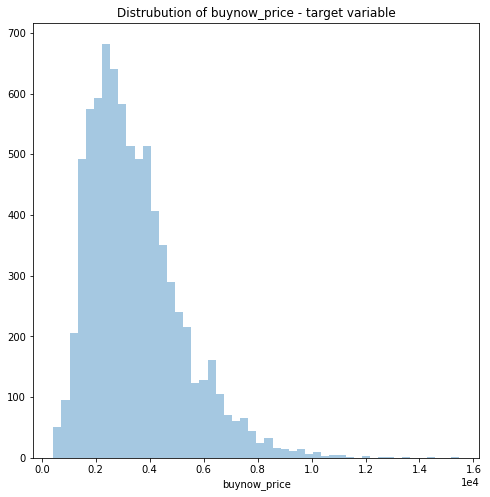

Skewness: 1.1918197625049383
Kurtosis: 2.2971867391894416


In [8]:
def plot_target_distribution(data, target_name):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.distplot(data[target_name], kde=False)
    ax.set_title("Distrubution of buynow_price - target variable")
    ax.ticklabel_format(style='sci', axis='both', scilimits=(-3,3))
    plt.show()
    skew = data[target_name].skew()
    kurt = data[target_name].kurt()
    print(f'Skewness: {skew}\nKurtosis: {kurt}')
plot_target_distribution(dataset, "buynow_price")

We are going to check whether there are some missing values in dataset

In [9]:
def missing_values(data):
    missing = data.isnull().sum()
    percent = data.isnull().sum()/data.isnull().count()
    data_missing = pd.concat([missing, percent], axis=1, keys=['Total', 'Percent'], sort=True).sort_values(by='Total', ascending=False)
    print(data_missing.head(6))
    return data_missing

And the plot all of these variables that contain some missing part

In [10]:
def plot_missing_values(data_missing, title="Title"):
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6))
    sns.barplot(data=data_missing[data_missing['Percent'] >0].reset_index(), x = 'index', 
                y='Percent')
    plt.xticks(rotation=70)
    plt.title(title)
    plt.show()

               Total   Percent
cpu_clock        936  0.119190
ram_type         864  0.110022
communication    782  0.099580
multimedia       708  0.090157
control          678  0.086336
os               650  0.082771


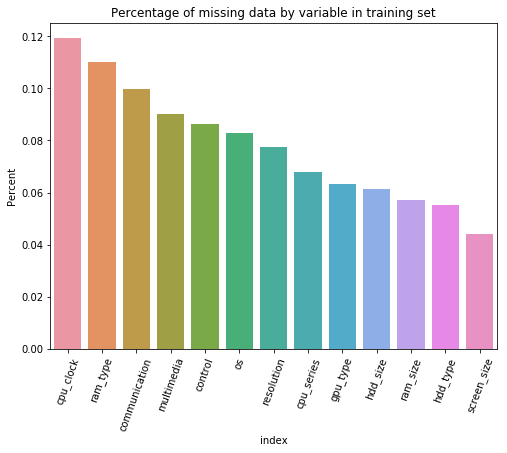

In [11]:
plot_missing_values(missing_values(dataset),"Percentage of missing data by variable in training set")

               Total   Percent
cpu_clock        451  0.116568
ram_type         415  0.107263
communication    401  0.103644
multimedia       356  0.092013
control          332  0.085810
os               322  0.083226


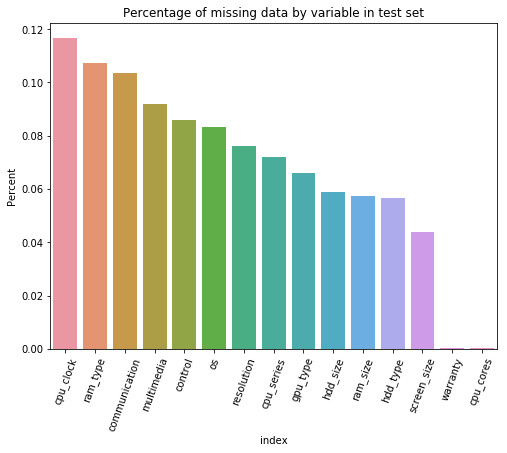

In [12]:
plot_missing_values(missing_values(dataset_test),"Percentage of missing data by variable in test set")

So one can see that the distribution of missing values is similar both in training and test set. Moreover, there are no missing values of target variable in our training set. We are going to split this to feature and target part then. Before we do that, we would like to see whether there are examples where majority of values are missing.

In [13]:
missing = dataset.loc[dataset.isnull().sum(axis=1)/dataset.shape[1] > 0.70, :]
missing.head(10)

,index,buynow_price,gpu_type,communication,resolution,cpu_cores,ram_size,os,hdd_type,control,multimedia,ram_type,cpu_clock,cpu_series,state,hdd_size,warranty,screen_size
22,10035,699.0,None,None,None,2,None,None,None,None,None,None,NaN,None,nowy,NaN,sprzedawcy,None
51,10077,6450.0,None,None,None,nie dotyczy,None,None,None,None,None,None,NaN,None,nowy,NaN,producenta,None
53,1008,1589.0,None,None,None,4,None,None,None,None,None,None,NaN,None,nowy,NaN,sprzedawcy,None
105,10161,4194.0,None,None,None,4,None,None,None,None,None,None,NaN,None,nowy,NaN,producenta,None
138,10208,4690.0,None,None,None,4,None,None,None,None,None,None,NaN,None,nowy,NaN,producenta,None
184,10269,1099.0,None,None,None,4,None,None,None,None,None,None,NaN,None,nowy,NaN,sprzedawcy,None
223,10320,2868.9,None,None,None,nie dotyczy,None,None,None,None,None,None,NaN,None,nowy,NaN,producenta,None
243,10351,1899.0,None,None,None,2,None,None,None,None,None,None,NaN,None,nowy,NaN,producenta,None
296,10423,1599.0,None,None,None,2,None,None,None,None,None,None,NaN,None,nowy,NaN,producenta,None
298,10428,8649.0,None,None,None,2,None,None,None,None,None,None,NaN,None,nowy,NaN,producenta,None


In [14]:
missing.isnull().sum()

index              0
buynow_price       0
gpu_type         255
communication    255
resolution       255
cpu_cores          0
ram_size         255
os               255
hdd_type         255
control          255
multimedia       255
ram_type         255
cpu_clock        255
cpu_series       255
state              0
hdd_size         255
warranty           0
screen_size      255
dtype: int64

There are 255 examples with missing values higher than 70%. Moreover we can see that besides state of the laptop and warranty type there is not much in this part of dataset. During this inspection another interesting thing about this dataset occured - some of the fields with number of cpu_cores are assigned as "nie dotyczy". We are going to treat them as missing values in our later analysis. We are also going to remove these examples from the dataset.

In [15]:
dataset = dataset.loc[~dataset['index'].isin(missing['index']), :]

In [16]:
dataset_X = dataset.loc[:, dataset.columns != 'buynow_price']
dataset_Y = dataset.loc[:,'buynow_price']

## Comparing distribution of features of training and test test

When one wants to predict a value of certain variable, we should make sure that distrubtion from all datasets that are used are coming from the same distribution. We are going to use Population Stability Index in order to verify whether these two samples come from similar distribution

## Detecting outliers

## Imputing missing values

So now when we can further inspect missing values in our samples

Given the fact that some of the parameters that are encourted in our analysis are almost surely found in any new laptop found on the market and where is a significant number of missing cases for these values

There is also a possibility that some of the used laptops being sold can be on the market as, for example, to obtain parts from them and as such may not have such thind as a hard drive or CPU. We are going to check how many of the laptops that have some missing parts are actually used

In [17]:
nan_ram_state = dataset.loc[dataset["ram_type"].isnull(), :]['state']
sum(nan_ram_state == 'nowy')/(len(nan_ram_state))

1.0

Ok, so this theory didn't work - so we should impute those missing values in some way

## Encoding of categorical variables

We are going to unlist operational system, as there is only one value per each row, to later encode this variable. Moreover we are going to change size of RAM memory to numerical variable and state of the laptop to binary one.

In [18]:
dataset_X.loc[:,'os'] = dataset_X['os'].apply(lambda x: x[0] if x is not None else x)
dataset_X.loc[:, 'ram_size'] = dataset_X['ram_size'].apply(lambda x: float(x.split()[0]) if x is not None else x)
dataset_X.loc[:, 'cpu_cores'].replace(to_replace = ['nie dotyczy'], value = [None], inplace=True)
dataset_X.loc[:, 'cpu_cores'] = dataset_X['cpu_cores'].apply(lambda x: float(x) if x is not None else x)

/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Since all variables that from preliminiary inpection contained list-type objects posses some information about additional items or features (like bluetooth or keyboard) we are going to treat them as one-hot encoded variables.

In [21]:
list_type_variables = ['communication', 'control', 'multimedia']
one_hot = [list_to_one_hot(dataset_X, var, 'index') for var in list_type_variables]
dataset_X_en_temp = reduce(lambda left,right: pd.merge(left,right,on='index', how='left'), [dataset_X, *one_hot])
dataset_X_en_temp = dataset_X_en_temp[dataset_X_en_temp.columns.difference(list_type_variables)]

From remaining categorical featues we are going to extract values from target encoding

In [22]:
names_trans = ["gpu_type", "resolution", "hdd_type", "ram_type", "cpu_series", 
               "state", "warranty", "screen_size", "os"]

In [23]:
target_encoder = TargetEncoder(columns=names_trans, nan_as_category=False, cv=5, inner_cv=3)

In [24]:
dataset_X_en = target_encoder.fit_transform(dataset_X_en_temp, dataset_Y)
for var in names_trans:
    dataset_X_en.loc[:, var] = dataset_X_en[var].apply(lambda x: float(x) if x is not None else x)
del(dataset_X_en_temp)

/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


## Training and validation split

Since we would prefer not to overfit our model, we are going to split our training set into training and validation set. We are going to use standard 80/20 ratio, since then our training set will still be bigger than test set and validation set is going to have about 40% of number of records from test set, so the proportions of records are within reasonable range.

In [29]:
X_train, X_val, Y_train, Y_val = train_test_split(dataset_X_en, dataset_Y, test_size=0.2, random_state=42)

## Xgboost

Without hyperparameter tuning

In [30]:
xgbr = xgb.XGBRegressor()

In [31]:
xgbr.fit(X_train, Y_train)

/Users/lukaszbala/anaconda3/envs/allegroenv/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [35]:
pred = xgbr.predict(X_val)

In [43]:
def rmse(y_true, y_pred):
    mse = np.mean((y_pred - y_true)** 2)
    return np.sqrt(mse)

In [44]:
rmse(pred, Y_val)

677.2976303044584

With hyperparameter tuning

In [56]:
EXPERIMENT_NAME = 'xgboost_first'

In [57]:
space = {
        'max_depth': hp.quniform("x_max_depth", 1, 13, 1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'gamma' : hp.uniform ('x_gamma', 0.,0.5),
        'colsample_bytree' : hp.uniform ('x_colsample_bytree', 0.4,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,1),
        'colsample_bylevel': hp.uniform('x_colsample_bylevel',0.4,1),
        'colsample_bynode' : hp.uniform('x_colsample_bynode',0.4,1),
        'reg_alpha': hp.uniform('x_reg_alpha',0,1)
        }

In [58]:
reg_optim = RegressorOptimizer(
    classifier=xgbr,
    space=space,
    metric=rmse
)

In [60]:
reg_optim.find_best_params(
    X_train,
    Y_train,
    experiments_path='../experiments/',
    experiments_name=EXPERIMENT_NAME,
    max_evals=500
)

  0%|          | 0/500 [00:00<?, ?it/s, best loss: ?]


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.